In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## To run in Colab

In [ ]:
# !pip install fastai==1.0.59
# !pip install -q torch==1.4.0 torchvision==0.5.0

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)
# !ls "/content/gdrive/My Drive/CVbyDL/data/minicity"

In [2]:
from fastai import *
from fastai.vision import *
import os
from glob import glob
from utils.databunch import *
from utils.metrics import acc_cityscapes, mIOU
from models.UNet.unet import UNet
from utils.evaluate import save_to_eval
from utils.losses import lovasz_softmax, dice_loss
from fastai.callbacks import ReduceLROnPlateauCallback

In [3]:
# base_dir = "/content/gdrive/My Drive/CVbyDL/data/minicity"
# test_dir = "/content/gdrive/My Drive/CVbyDL/data/cityspaces"
base_dir = "data/minicity"
test_dir = "data/cityspaces"

In [4]:
data = get_databunch(base_dir, size =(384,768) , bs=4)

In [5]:
metrics= [acc_cityscapes, mIOU]


## Prepare UNet model

In [6]:
learn = unet_learner(data,models.resnet18, metrics=metrics,pretrained=False, opt_func=optim.SGD, wd = 0.001)

In [7]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


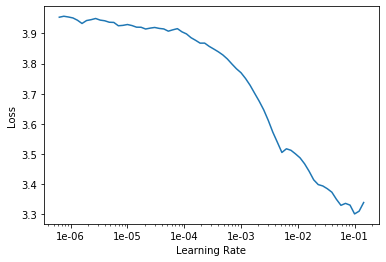

In [17]:
lr_find(learn)
learn.recorder.plot()

In [8]:
lr = 1e-3
learn.fit_one_cycle(40, lr, pct_start=0.9)

epoch,train_loss,valid_loss,acc_cityscapes,mIOU,time
0,4.042633,3.555323,0.035560,0.008976,01:14
1,3.487668,3.019099,0.377623,0.039659,01:05
2,2.800707,2.272957,0.542490,0.061547,01:05
3,2.323917,2.063006,0.568371,0.070070,01:05
4,2.040654,1.876424,0.608886,0.081186,01:05
5,1.830214,1.706207,0.627783,0.088913,01:05
6,1.690871,1.608636,0.654688,0.105836,01:05
7,1.566244,1.589710,0.643214,0.112416,01:05
8,1.477210,1.582812,0.648310,0.110346,01:05
9,1.409763,1.466588,0.667797,0.125952,01:04


In [9]:
learn.save('dynamic_unet')

## Lovasz loss

In [11]:
learn = unet_learner(data,models.resnet18, metrics=metrics,pretrained=False, opt_func=optim.SGD, wd = 0.001)


In [12]:
learn.loss_func = lovasz_softmax

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


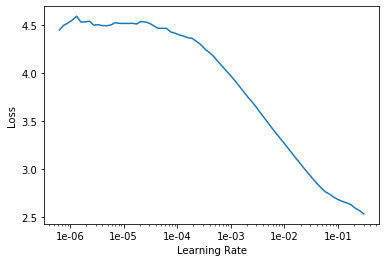

In [13]:
lr_find(learn)
learn.recorder.plot()

In [14]:
lr = 1e-3
learn.fit_one_cycle(40, lr, pct_start=0.9)

epoch,train_loss,valid_loss,acc_cityscapes,mIOU,time
0,2.041676,1.364709,0.009092,0.001841,01:26
1,1.399962,1.078261,0.016073,0.002333,01:26
2,1.136388,0.975128,0.012453,0.002041,01:26
3,1.003671,0.908963,0.011762,0.001988,01:26
4,0.926544,0.862401,0.015227,0.002377,01:26
5,0.868655,0.816227,0.018404,0.002990,01:26
6,0.821026,0.778995,0.012120,0.002329,01:25
7,0.779530,0.742683,0.013073,0.003197,01:25
8,0.748858,0.715109,0.013750,0.004512,01:25
9,0.724680,0.692661,0.013155,0.004770,01:25


In [15]:
learn.save('dynamic_unet_lovasz')

## Dice loss

In [6]:
learn = unet_learner(data,models.resnet18, metrics=metrics,pretrained=False, wd = 0.001)


In [7]:
learn.loss_func = dice_loss

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr = 1e-4
learn.fit_one_cycle(40, lr)

epoch,train_loss,valid_loss,acc_cityscapes,mIOU,time
0,0.982590,0.973646,0.213816,0.013829,01:27
1,0.968788,0.955058,0.290864,0.033209,01:17
2,0.950914,0.925704,0.340218,0.062920,01:17
3,0.932823,0.909156,0.368936,0.075721,01:18
4,0.923351,0.896388,0.384591,0.082918,01:18
5,0.911785,0.882396,0.366825,0.111414,01:18
6,0.906562,0.881722,0.364396,0.110962,01:18
7,0.900313,0.868932,0.369612,0.117097,01:18
8,0.898897,0.878275,0.353970,0.121888,01:18
9,0.883741,0.849247,0.384326,0.160459,01:18


In [ ]:
learn.save('dynamic_unet_dice')

## test on competition dataset

In [11]:
learn.load('dynamic_unet')

Learner(data=ImageDataBunch;

Train: LabelList (200 items)
x: SegmentationItemList
Image (3, 512, 1024),Image (3, 512, 1024),Image (3, 512, 1024),Image (3, 512, 1024),Image (3, 512, 1024)
y: SegmentationLabelList
ImageSegment (1, 512, 1024),ImageSegment (1, 512, 1024),ImageSegment (1, 512, 1024),ImageSegment (1, 512, 1024),ImageSegment (1, 512, 1024)
Path: data/minicity/leftImg8bit;

Valid: LabelList (100 items)
x: SegmentationItemList
Image (3, 512, 1024),Image (3, 512, 1024),Image (3, 512, 1024),Image (3, 512, 1024),Image (3, 512, 1024)
y: SegmentationLabelList
ImageSegment (1, 512, 1024),ImageSegment (1, 512, 1024),ImageSegment (1, 512, 1024),ImageSegment (1, 512, 1024),ImageSegment (1, 512, 1024)
Path: data/minicity/leftImg8bit;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [12]:
test_dataset = get_databunch(test_dir, size = (512,1024), bs =2)

In [13]:
learn.validate(test_dataset.valid_dl)

[0.822937, tensor(0.8330), tensor(0.2316)]

## Preadict and save

In [14]:
save_to_eval(learn, test_dataset)    


In [15]:
!python toolkit/semantic-segmentation/evaluate.py --results results/ --minicity data/cityspaces/

Evaluating 500 pairs of images...
Images Processed: 500 

-------------- ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------- 
              |  u   |  e   |  r   |  o   |  s   |  d   |  g   |  r   |  s   |  p   |  r   |  b   |  w   |  f   |  g   |  b   |  t   |  p   |  p   |  t   |  t   |  v   |  t   |  s   |  p   |  r   |  c   |  t   |  b   |  c   |  t   |  t   |  m   |  b   | Prior |
-------------- ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------ ------- 
    unlabeled | [31;1 0.00   [31;1 0.00   [31;1 0.00   [31;1 0.00   [31;1 0.00   [31;1 0.00   [31;1 0.00   [31;1 0.00   [31;1 0.00   [31;1 0.0